In [1]:
import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.nn import init
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import functional as FT

In [2]:
train = CIFAR10(
    'data', 
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]), 
    download=True
)
train_dl = DataLoader(train, 32, shuffle=True, num_workers=4, drop_last=True)

test = CIFAR10(
    'validate', 
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]), 
    download=True
)
test_dl = DataLoader(test, 32, shuffle=False, num_workers=4, drop_last=True)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [3]:
LATENT_SPACE_DIM = 24

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
            
        
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, LATENT_SPACE_DIM)
        self.fc_bn2 = nn.BatchNorm1d(LATENT_SPACE_DIM)

        self.fc3 = nn.Linear(LATENT_SPACE_DIM, 10)

        self.fc4 = nn.Linear(LATENT_SPACE_DIM, 2)
    
    def forward(self, x):        
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, 8 * 8 * 64)

        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = F.relu(self.fc_bn2(self.fc2(x)))
        supervised = self.fc3(x)
        embedding = self.fc4(x)
        return x, supervised, embedding

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(LATENT_SPACE_DIM, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64 * 8 * 8)
        self.fc_bn2 = nn.BatchNorm1d(64 * 8 * 8)

        self.conv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(3)
        )
    
    def forward(self, z):
        x = F.relu(self.fc_bn1(self.fc1(z)))
        x = F.relu(self.fc_bn2(self.fc2(x))).view(-1, 64, 8, 8)
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        return F.sigmoid(x)

In [6]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.enc_mu = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)
        self.enc_logvar = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)

    def forward(self, x):
        h, supervised, embedding = self.encoder(x)
        
        mu, logvar = self.enc_mu(h), self.enc_logvar(h)
        sigma = (logvar * 0.5).exp_()
        z = mu + sigma * torch.randn_like(sigma)
        
        xh = self.decoder(z)
        
        return (mu, sigma), xh, supervised, embedding
    
    def sample(self, n=1):
        z = torch.randn(n, LATENT_SPACE_DIM, 
                        dtype=torch.float)
        
        xh = self.decoder(z)
        xh = xh.detach()
        
        return xh

In [7]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
device_cpu = torch.device("cpu")

In [8]:
model = VAE(Encoder(), Decoder())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

In [9]:
def latent_loss(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

In [12]:
classifier_criterion = nn.CrossEntropyLoss()
classifier_cent_cri = CenterLoss(num_classes=10, feat_dim=2, use_gpu=True)

model.train()

for epoch in tqdm.tqdm_notebook(range(1, 40)):
    total_loss = 0
    without_total_loss = 0
    center_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        h, xh, supervised, embedding = model(x)
        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h) + classifier_criterion(supervised, y) + classifier_cent_cri(embedding.float(), y)

        without_supervised_loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        without_total_loss += without_supervised_loss.item()

        center_loss += classifier_cent_cri(embedding.float(), y)
    
    total_loss /= len(train_dl)
    without_total_loss /= len(train_dl)
    center_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss} without_loss={without_total_loss} center_loss={center_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=1 loss=3.8727949344852366 without_loss=0.7202029761675836 center_loss=1.7468191385269165


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=2 loss=2.9337611618939494 without_loss=0.6531061036333384 center_loss=1.2860760688781738


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=3 loss=2.5439288007923033 without_loss=0.6466303110198999 center_loss=1.0671745538711548


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=4 loss=2.2784622709210796 without_loss=0.6453855619616758 center_loss=0.9224242568016052


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=5 loss=2.0545078957126632 without_loss=0.6447729164980133 center_loss=0.7975543141365051


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=6 loss=1.8647975453799268 without_loss=0.6452529087719936 center_loss=0.696392297744751


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=7 loss=1.703292215145199 without_loss=0.6454076666227528 center_loss=0.6125667095184326


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=8 loss=1.585448954573972 without_loss=0.6452780529646807 center_loss=0.5556892156600952


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=9 loss=1.469976834351824 without_loss=0.6453317910547293 center_loss=0.49972912669181824


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=10 loss=1.4015419604912611 without_loss=0.645450832596509 center_loss=0.46884703636169434


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=11 loss=1.3265805241774657 without_loss=0.6455527230734709 center_loss=0.43432527780532837


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=12 loss=1.2713075379784984 without_loss=0.6454825595154805 center_loss=0.40531685948371887


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=13 loss=1.218936915892187 without_loss=0.6453438227979535 center_loss=0.3831701874732971


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=14 loss=1.184750935484902 without_loss=0.6453324616260626 center_loss=0.36637410521507263


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=15 loss=1.1552198069425308 without_loss=0.6447054392702296 center_loss=0.3493444621562958


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=16 loss=1.1183816020910016 without_loss=0.6446832445153201 center_loss=0.3331640064716339


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=17 loss=1.096450555110863 without_loss=0.6443203928070703 center_loss=0.3211266100406647


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=18 loss=1.0771757161266216 without_loss=0.6441748718446104 center_loss=0.31239011883735657


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=19 loss=1.0636435332737872 without_loss=0.6438835391085523 center_loss=0.3056921660900116


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=20 loss=1.0351601170516656 without_loss=0.6438447339662975 center_loss=0.2914491593837738


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=21 loss=1.0285519879697684 without_loss=0.6438902359689549 center_loss=0.2864190340042114


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=22 loss=1.0145443973254302 without_loss=0.6436720848007178 center_loss=0.2779274880886078


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=23 loss=0.9946950983909577 without_loss=0.6435789587632031 center_loss=0.2669433653354645


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=24 loss=0.9857814902303771 without_loss=0.6432886368257593 center_loss=0.261427104473114


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=25 loss=0.9769875037838036 without_loss=0.6430783357647714 center_loss=0.2563612759113312


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=26 loss=0.9652241634422014 without_loss=0.6429854155197339 center_loss=0.25004974007606506


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=27 loss=0.956618929832754 without_loss=0.6424602634164954 center_loss=0.2458779662847519


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=28 loss=0.951440155506134 without_loss=0.642356478526864 center_loss=0.24221280217170715


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=29 loss=0.9385823750541702 without_loss=0.6421921989676589 center_loss=0.23650074005126953


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=30 loss=0.9254442996771174 without_loss=0.6421615027663955 center_loss=0.2245497852563858


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=31 loss=0.9287625123840899 without_loss=0.6420294081890018 center_loss=0.22727373242378235


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=32 loss=0.9242968128829546 without_loss=0.6417802622620489 center_loss=0.2250918745994568


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=33 loss=0.9104309995180514 without_loss=0.6415552204229157 center_loss=0.21614760160446167


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=34 loss=0.9036132796320506 without_loss=0.641479132842468 center_loss=0.20881056785583496


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=35 loss=0.8922819975243641 without_loss=0.6412264158646367 center_loss=0.20416396856307983


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=36 loss=0.8953615161810886 without_loss=0.6412488774667171 center_loss=0.206170916557312


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=37 loss=0.8938593590457979 without_loss=0.6411114799457384 center_loss=0.20433029532432556


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=38 loss=0.8799991826699729 without_loss=0.6402510471746955 center_loss=0.19460152089595795


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=39 loss=0.8825786658652155 without_loss=0.6405752615647798 center_loss=0.19806094467639923


In [12]:
classifier_criterion = nn.CrossEntropyLoss()
classifier_cent_cri = CenterLoss(num_classes=10, feat_dim=2, use_gpu=True)

model.train()

for epoch in tqdm.tqdm_notebook(range(1, 40)):
    total_loss = 0
    without_total_loss = 0
    center_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        h, xh, supervised, embedding = model(x)
        # loss = F.binary_cross_entropy(xh, x) + latent_loss(*h) + classifier_criterion(supervised, y) + classifier_cent_cri(embedding.float(), y)

        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h) + classifier_criterion(supervised, y)

        without_supervised_loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        without_total_loss += without_supervised_loss.item()

        center_loss += classifier_cent_cri(embedding.float(), y)
    
    total_loss /= len(train_dl)
    without_total_loss /= len(train_dl)
    center_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss} without_loss={without_total_loss} center_loss={center_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=1 loss=1.9602000585896715 without_loss=0.7102782827409678 center_loss=1.6174007654190063


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=2 loss=1.513067528471904 without_loss=0.6421063825507171 center_loss=1.8312393426895142


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=3 loss=1.3402466783526612 without_loss=0.6365861915214114 center_loss=1.9068607091903687


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=4 loss=1.2145799286234242 without_loss=0.6352461655832894 center_loss=2.0441701412200928


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=5 loss=1.1108429330030263 without_loss=0.6346209432724649 center_loss=2.1474900245666504


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=6 loss=1.0224934919771862 without_loss=0.6344919872497627 center_loss=2.219242572784424


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=7 loss=0.9615331538660731 without_loss=0.6345275154339672 center_loss=2.28448486328125


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=8 loss=0.9004299292643764 without_loss=0.6343451730725708 center_loss=2.3546488285064697


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=9 loss=0.8680420951409773 without_loss=0.6339968167789156 center_loss=2.455308675765991


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=10 loss=0.8408756237405516 without_loss=0.6337954604213583 center_loss=2.5033740997314453


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=11 loss=0.8147572269818236 without_loss=0.6336065571607304 center_loss=2.5272443294525146


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=12 loss=0.8007813014385795 without_loss=0.6331801380909664 center_loss=2.5638480186462402


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=13 loss=0.7833803014474398 without_loss=0.6326739636563461 center_loss=2.585707187652588


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=14 loss=0.7695530804491837 without_loss=0.6321249303530792 center_loss=2.6167728900909424


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=15 loss=0.7576953975934531 without_loss=0.6321550161218826 center_loss=2.667273759841919


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=16 loss=0.7525700451317273 without_loss=0.6320963137510034 center_loss=2.6809093952178955


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=17 loss=0.7439368628203945 without_loss=0.6318965032219734 center_loss=2.758594036102295


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=18 loss=0.7394849912152552 without_loss=0.6314189077644738 center_loss=2.782119035720825


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=19 loss=0.7321627503320594 without_loss=0.63084260964821 center_loss=2.7237651348114014


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=20 loss=0.7322465551494789 without_loss=0.6305727591969444 center_loss=2.720036029815674


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=21 loss=0.7190076327583396 without_loss=0.6300266140859655 center_loss=2.7944464683532715


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=22 loss=0.7245133803076994 without_loss=0.6300545638944672 center_loss=2.8097240924835205


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=23 loss=0.7115048355924946 without_loss=0.6298637753030555 center_loss=2.8854875564575195


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=24 loss=0.7166577013598209 without_loss=0.6293325929803518 center_loss=2.867603063583374


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=25 loss=0.7072954058799793 without_loss=0.6291520191063191 center_loss=2.9074413776397705


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=26 loss=0.6997240600909528 without_loss=0.6285728638211835 center_loss=2.927323341369629


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=27 loss=0.701856938695175 without_loss=0.6285509922363999 center_loss=2.901224374771118


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=28 loss=0.7001974916183383 without_loss=0.6283914572756055 center_loss=2.9521431922912598


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=29 loss=0.6944751346462362 without_loss=0.6280254549162031 center_loss=2.8939621448516846


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=30 loss=0.6922373171041931 without_loss=0.6278648474915537 center_loss=2.965003490447998


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=31 loss=0.6966413685744306 without_loss=0.6276129314749861 center_loss=2.931884765625


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=32 loss=0.6925495750009631 without_loss=0.6273945957689371 center_loss=2.960510730743408


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=33 loss=0.6853603323046285 without_loss=0.6269685395166907 center_loss=2.961819648742676


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=34 loss=0.6840041344663398 without_loss=0.6268811968087235 center_loss=2.9618172645568848


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=35 loss=0.6826186782648255 without_loss=0.6266574279981142 center_loss=2.891242742538452


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=36 loss=0.6833160740159996 without_loss=0.6264706872565798 center_loss=2.9459340572357178


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=37 loss=0.6791094227881194 without_loss=0.6261635577251298 center_loss=2.9640917778015137


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=38 loss=0.6794262581079168 without_loss=0.6261029415567156 center_loss=2.9668519496917725


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=39 loss=0.6797124420634916 without_loss=0.6257505097096159 center_loss=2.946493625640869


In [11]:
classifier_criterion = nn.CrossEntropyLoss()
classifier_cent_cri = CenterLoss(num_classes=10, feat_dim=2, use_gpu=True)

model.train()

for epoch in tqdm.tqdm_notebook(range(1, 40)):
    total_loss = 0
    without_total_loss = 0
    center_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        h, xh, supervised, embedding = model(x)
        # loss = F.binary_cross_entropy(xh, x) + latent_loss(*h) + classifier_criterion(supervised, y) + classifier_cent_cri(embedding.float(), y)

        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)

        without_supervised_loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        without_total_loss += without_supervised_loss.item()

        center_loss += classifier_cent_cri(embedding.float(), y)
    
    total_loss /= len(train_dl)
    without_total_loss /= len(train_dl)
    center_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss} without_loss={without_total_loss} center_loss={center_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=1 loss=0.6755034858682855 without_loss=0.6755034858682855 center_loss=2.915266275405884


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=2 loss=0.6064029783201279 without_loss=0.6064029783201279 center_loss=3.132788896560669


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=3 loss=0.6012373987523297 without_loss=0.6012373987523297 center_loss=3.1783111095428467


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=4 loss=0.5989038741237528 without_loss=0.5989038741237528 center_loss=3.176600217819214


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=5 loss=0.5974895687017795 without_loss=0.5974895687017795 center_loss=3.159989595413208


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=6 loss=0.5961458663934324 without_loss=0.5961458663934324 center_loss=3.1437923908233643


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=7 loss=0.5950399097651434 without_loss=0.5950399097651434 center_loss=3.1196632385253906


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=8 loss=0.5941135432289749 without_loss=0.5941135432289749 center_loss=3.0888378620147705


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=9 loss=0.5934709545592187 without_loss=0.5934709545592187 center_loss=3.0874595642089844


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=10 loss=0.592750087437648 without_loss=0.592750087437648 center_loss=3.092057228088379


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=11 loss=0.5918249288304361 without_loss=0.5918249288304361 center_loss=3.0923681259155273


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=12 loss=0.5906945615816055 without_loss=0.5906945615816055 center_loss=3.0825181007385254


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=13 loss=0.5900952794640378 without_loss=0.5900952794640378 center_loss=3.073045492172241


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=14 loss=0.5895038066997113 without_loss=0.5895038066997113 center_loss=3.0393996238708496


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=15 loss=0.5890704359425167 without_loss=0.5890704359425167 center_loss=3.0112648010253906


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=16 loss=0.5886985243664203 without_loss=0.5886985243664203 center_loss=2.985748529434204


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=17 loss=0.5887214681861037 without_loss=0.5887214681861037 center_loss=2.9557669162750244


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=18 loss=0.5884644867287098 without_loss=0.5884644867287098 center_loss=2.9248430728912354


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=19 loss=0.5880188551205526 without_loss=0.5880188551205526 center_loss=2.918320417404175


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=20 loss=0.587823214627106 without_loss=0.587823214627106 center_loss=2.903270721435547


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=21 loss=0.5875545711889768 without_loss=0.5875545711889768 center_loss=2.88309383392334


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=22 loss=0.5875243238923492 without_loss=0.5875243238923492 center_loss=2.865246295928955


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=23 loss=0.5873611053110848 without_loss=0.5873611053110848 center_loss=2.848073720932007


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=24 loss=0.5874931747797356 without_loss=0.5874931747797356 center_loss=2.831049680709839


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=25 loss=0.5875664212944871 without_loss=0.5875664212944871 center_loss=2.8126766681671143


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=26 loss=0.5871580543423431 without_loss=0.5871580543423431 center_loss=2.8025078773498535


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=27 loss=0.5871233766500227 without_loss=0.5871233766500227 center_loss=2.7818212509155273


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=28 loss=0.5868766347516361 without_loss=0.5868766347516361 center_loss=2.763688087463379


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=29 loss=0.5867394245159305 without_loss=0.5867394245159305 center_loss=2.751579523086548


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=30 loss=0.5868637705658218 without_loss=0.5868637705658218 center_loss=2.7404494285583496


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=31 loss=0.5865220432092224 without_loss=0.5865220432092224 center_loss=2.7235686779022217


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=32 loss=0.586647052122292 without_loss=0.586647052122292 center_loss=2.7075252532958984


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=33 loss=0.5864655031666408 without_loss=0.5864655031666408 center_loss=2.693283796310425


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=34 loss=0.5864958464336151 without_loss=0.5864958464336151 center_loss=2.6817398071289062


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=35 loss=0.5863739800437923 without_loss=0.5863739800437923 center_loss=2.6761436462402344


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=36 loss=0.5861993164549106 without_loss=0.5861993164549106 center_loss=2.6647849082946777


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=37 loss=0.5864722761164554 without_loss=0.5864722761164554 center_loss=2.651714324951172


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=38 loss=0.5860527360027181 without_loss=0.5860527360027181 center_loss=2.645259380340576


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=39 loss=0.5859904035105443 without_loss=0.5859904035105443 center_loss=2.641341209411621


In [13]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device_cpu))

        x = x.to(device_cpu)
        y = y.long().to(device_cpu)
        h, xh, supervised, embedding = model(x)

        # z = torch.Tensor.cpu(embedding)
        z = embedding.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=1.1)
        if i > num_batches:
            plt.colorbar()
            break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


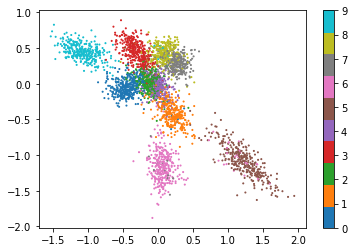

In [42]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


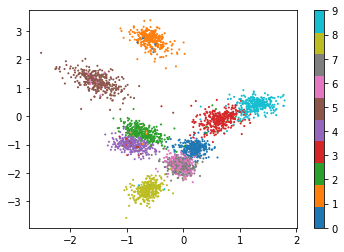

In [14]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


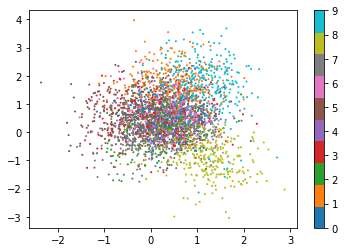

In [45]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


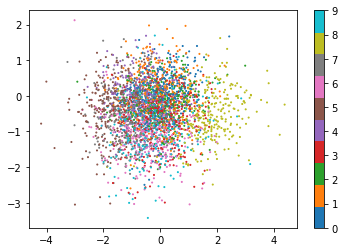

In [15]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


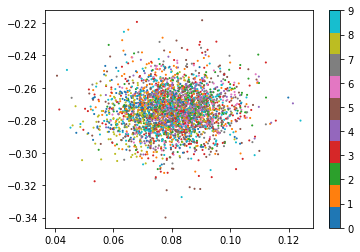

In [48]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


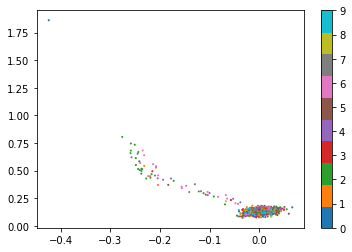

In [14]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

In [10]:
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(x, self.centers.t(), beta=1, alpha=-2)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

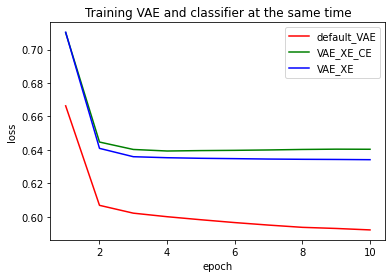

In [4]:
import numpy as np
import matplotlib.pyplot as plt

epoch_number = 11
epoch_list = np.arange(1, epoch_number)

default_loss = [0.6663595125098235, 0.6068935943397761, 0.6022147364561444, 0.600091241347805, 0.5982781114788885,
               0.5965847693164278, 0.5950872819112296, 0.5937389107122922, 0.593070736386254, 0.5922001395732279]

XE_CE_loss = [0.7101134765087108, 0.644718940523614, 0.6402859157010932, 0.6393618405475812, 0.6396092641597826,
             0.6397641402276927, 0.6399906170810841, 0.6402911150424947, 0.6404639394350455, 0.6404050318059177]

XE_loss = [0.7103434821326052, 0.6409441607404457, 0.6359551038387948, 0.6353512449087467, 0.6350051874769482,
          0.6347951622305392, 0.6345522165603735, 0.6344047640563584, 0.634311778788072, 0.6341740849991919]

plt.figure()
line1, = plt.plot(epoch_list, default_loss, color='r', label='default_VAE')
line2, = plt.plot(epoch_list, XE_CE_loss, color='g', label='VAE_XE_CE')
line3, = plt.plot(epoch_list, XE_loss, color='b', label='VAE_XE')
plt.title('Training VAE and classifier at the same time')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(handles=[line1, line2, line3])
plt.show()

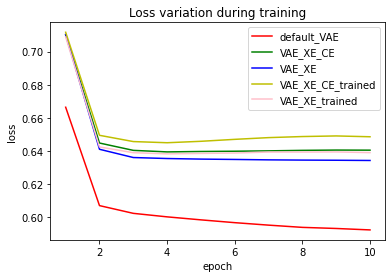

In [5]:
import numpy as np
import matplotlib.pyplot as plt

epoch_number = 11
epoch_list = np.arange(1, epoch_number)

default_loss = [0.6663595125098235, 0.6068935943397761, 0.6022147364561444, 0.600091241347805, 0.5982781114788885,
               0.5965847693164278, 0.5950872819112296, 0.5937389107122922, 0.593070736386254, 0.5922001395732279]

XE_CE_loss = [0.7101134765087108, 0.644718940523614, 0.6402859157010932, 0.6393618405475812, 0.6396092641597826,
             0.6397641402276927, 0.6399906170810841, 0.6402911150424947, 0.6404639394350455, 0.6404050318059177]

XE_CE_loss_trained = [0.7116850453515975, 0.6493884769581955, 0.645601911940129, 0.6448984512064735, 0.6457669150737733,
             0.6469438697250796, 0.6479896111616558, 0.6486376034770824, 0.6490067084833846, 0.6485067084833846]

XE_loss = [0.7103434821326052, 0.6409441607404457, 0.6359551038387948, 0.6353512449087467, 0.6350051874769482,
          0.6347951622305392, 0.6345522165603735, 0.6344047640563584, 0.634311778788072, 0.6341740849991919]

XE_loss_trained = [0.7088511062645271, 0.6423362151227138, 0.6388846698781134, 0.6381695695250044, 0.6384233285919805,
          0.6386838946086039, 0.6392568956187684, 0.6392535060911264, 0.6393300215886588, 0.6389300215886588]

plt.figure()
line1, = plt.plot(epoch_list, default_loss, color='r', label='default_VAE')
line2, = plt.plot(epoch_list, XE_CE_loss, color='g', label='VAE_XE_CE')
line3, = plt.plot(epoch_list, XE_loss, color='b', label='VAE_XE')
line4, = plt.plot(epoch_list, XE_CE_loss_trained, color='y', label='VAE_XE_CE_trained')
line5, = plt.plot(epoch_list, XE_loss_trained, color='pink', label='VAE_XE_trained')
plt.title('Loss variation during training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(handles=[line1, line2, line3, line4, line5])
plt.show()